# Detailed example

This overview of the most important functions repeats the previous 30-seconds-example, but in more detail and shows additional functionality and alternative steps.

## Authentificate & access project

In [1]:
import up42

In [2]:
up42.authenticate(project_id="your project ID string", project_api_key="your-project-API-key")

Alternatively, if you want to authenticate with a config file (make sure config.json file is on the current folder or set the path)

In [ ]:
up42.authenticate(cfg_file="config.json")
catalog = up42.initialize_catalog()

Access your project for further configuration

In [3]:
project = up42.initialize_project()
project

Project(name: 30 Seconds Example, project_id: 1d53e295-95a7-423d-9f09-68bbbebf74c2, description: , createdAt: 2022-03-10T12:50:35.293635Z)

Get information about the available blocks to later construct your workflow.

In [ ]:
up42.get_blocks(basic=True)

## Create or access the workflow
You can either create a new workflow, use project.get_workflows() to get all existing workflows within the project, or access an exisiting workflow directly via its workflow_id.

A new workflow is created and filled with tasks ([Sentinel-2 data](https://marketplace.up42.com/block/018dfb34-fc19-4334-8125-14fd7535f979), 
[Land-Surface-Temperature](https://marketplace.up42.com/block/34767300-5caf-472b-a684-a351212b5c14)). 
The area of interest and workflow parameters are defined. After running the job, 
the results are downloaded and visualized.

In [4]:
# Create a new, empty workflow.
workflow = project.create_workflow(name="30-seconds-workflow", use_existing=False)
workflow

Workflow(name: 30-seconds-workflow, workflow_id: 25127cbd-a593-478d-9aae-fac66e8a5663, description: , createdAt: 2022-03-21T09:57:36.932650Z, project_id: 1d53e295-95a7-423d-9f09-68bbbebf74c2

In [5]:
# Add workflow tasks
input_tasks = ["Sentinel-2 L2A Visual (GeoTIFF)", "Sharpening Filter"]
workflow.add_workflow_tasks(input_tasks=input_tasks)
workflow.get_workflow_tasks(basic=True) # Check the added tasks.

{'esa-s2-l2a-gtiff-visual:1': '1.2.3', 'sharpening:1': '2.1.2'}

In [ ]:
# Alternative 1 for defining workflow: Get all existing workflows within the project.
# all_workflows = project.get_workflows()
# workflow = all_workflows[0]
# workflow

In [ ]:
# Alternative 2 for defining workflow: Directly access the existing workflow the id (has to exist within the accessed project).
# UP42_WORKFLOW_ID="workflow-ID"
# workflow = up42.initialize_workflow(workflow_id=UP42_WORKFLOW_ID)
# workflow

## Select the aoi

There are multiple ways to select an aoi, you can:
- Provide aoi the geometry directly in code as a FeatureCollection, Feature, GeoDataFrame, shapely Polygon or list of bounds coordinates.
- Use up42.draw_aoi() to draw the aoi and export it as a geojson.
- Use up42.read_vector_file() to read a geojson, json, shapefile, kml or wkt file.
- Use up42.get_example_aoi() to read multiple provided sample aois.

In [6]:
aoi = [13.375966, 52.515068, 13.378314, 52.516639]

In [ ]:
# Alternative 1 for AOI definition (Adding a vector file)
#aoi = up42.read_vector_file("data/aoi_berlin.geojson", as_dataframe=True)
#aoi.head(1)

In [ ]:
# Alternative 2 for AOI definition (Using an AOI example from our SDK)
#aoi = up42.get_example_aoi(location="Berlin")
#aoi

In [17]:
up42.draw_aoi()

## Select the workflow parameters

There are also multiple ways to construct the workflow input parameters, you can:
- Provide the parameters directly in code as a json string.
- Use .get_parameters_info() to get a an overview of all potential parameters for the selected workflow and information about the parameter defaults and ranges.
- Use .get_input_parameters(aoi_type="bbox", aoi_geometry=aoi) to construct the parameters with the provided aoi and all default parameters. Selecting the aoi_type is independent from the provided aoi, you can e.g. provide a irregular Polygon and still select aoi_type="bbox", then the bounding box of the polygon will be selected.

In [8]:
workflow.get_parameters_info()

{'esa-s2-l2a-gtiff-visual:1': {'ids': {'type': 'array', 'default': None},
  'bbox': {'type': 'array', 'default': None},
  'time': {'type': 'dateRange',
   'default': '2018-12-01T00:00:00+00:00/2021-12-31T23:59:59+00:00'},
  'limit': {'type': 'integer', 'default': 1, 'minimum': 1},
  'contains': {'type': 'geometry'},
  'intersects': {'type': 'geometry'},
  'max_cloud_cover': {'type': 'integer',
   'default': 100,
   'maximum': 100,
   'minimum': 0}},
 'sharpening:1': {'strength': {'type': 'string', 'default': 'medium'}}}

In [9]:
input_parameters = workflow.construct_parameters(geometry=aoi, geometry_operation="bbox", limit=1)

# Further update the input_parameters manually
input_parameters["esa-s2-l2a-gtiff-visual:1"].update({"max_cloud_cover":10})
input_parameters

{'esa-s2-l2a-gtiff-visual:1': {'time': '2018-12-01T00:00:00+00:00/2021-12-31T23:59:59+00:00',
  'limit': 1,
  'max_cloud_cover': 10,
  'bbox': [13.375966, 52.515068, 13.378314, 52.516639]},
 'sharpening:1': {'strength': 'medium'}}

In [10]:
workflow

Workflow(name: 30-seconds-workflow, workflow_id: 25127cbd-a593-478d-9aae-fac66e8a5663, description: , createdAt: 2022-03-21T09:57:36.932650Z, project_id: 1d53e295-95a7-423d-9f09-68bbbebf74c2

## Price estimation & Test Job

Price estimation allows you to get information about the consumption of your pipeline. Price units are given in credit units.

In [11]:
workflow.estimate_job(input_parameters)

{'esa-s2-l2a-gtiff-visual:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0.027816,
    'max': 0.027816},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}},
 'sharpening:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0.027816,
    'max': 0.027816},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 308, 'max': 349},
   'credit': {'min': 1, 'max': 1}}}}

## Pre-testing job

In [12]:
# Run a test job to query data availability and check the configuration.
test_job = workflow.test_job(input_parameters=input_parameters, track_status=True)
test_results = test_job.get_results_json()
test_results

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'bbox': [13.375966, 52.515068, 13.378314, 52.516639],
   'id': 'S2A_32UQD_20211202_0_L2A',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.378314, 52.515068],
      [13.375966, 52.515068],
      [13.375966, 52.516639],
      [13.378314, 52.516639],
      [13.378314, 52.515068]]]},
   'properties': {'datetime': '2021-12-02T10:26:10Z',
    'platform': 'sentinel-2a',
    'constellation': 'sentinel-2',
    'instruments': ['msi'],
    'gsd': 10,
    'view:off_nadir': 0,
    'proj:epsg': 32632,
    'sentinel:utm_zone': 32,
    'sentinel:latitude_band': 'U',
    'sentinel:grid_square': 'QD',
    'sentinel:sequence': '0',
    'sentinel:product_id': 'S2A_MSIL2A_20211202T102401_N0301_R065_T32UQD_20211202T133227',
    'sentinel:data_coverage': 100,
    'eo:cloud_cover': 7.34,
    'sentinel:valid_cloud_cover': True,
    'created': '2021-12-02T17:44:45.457Z',
    'updated': '2021-12-02T17:44:45.457Z'}}]}

## Run the workflow & download results

In [13]:
# Run the actual job.
job = workflow.run_job(input_parameters=input_parameters, track_status=True)

## Download & Display results

In [ ]:
# Download job result (default downloads to Desktop). Only works after download is finished.
results_fp = job.download_results()

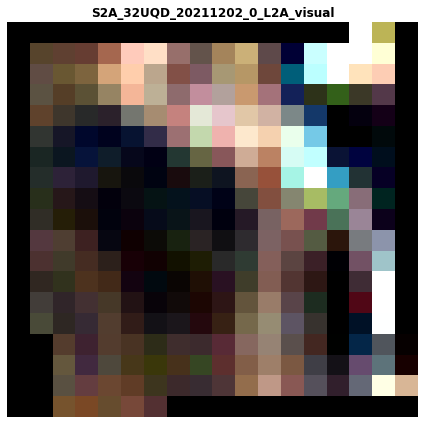

In [16]:
job.plot_results(figsize=(6,6))